## Background

This is the HR datasets. In our dataset 50000 rows and 14 columns. Every year, around 5% of its employees have promoted in the company. so, we have the check employee is promoted or not? 



## Business Objective

Our goal is to build a machine learning model that will predict whether employeers in a given dataset will be eligible for promotion. To achieve this, we will first explore the data and prepare it for modeling. We will then build and hyperoptimize the most successful model. Finally, we will test the model on the test data to predict whether employeers are eligible for promotion.



### IMPORTING LIBRARIES

In [610]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [611]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)
import plotly.express as px

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings("ignore")

# For saving models
import pickle 

## LOAD AND DESCRIBE DATA

In [612]:
df= pd.read_csv("train.csv")
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


### DATA OBSERVATION

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [614]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [615]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [616]:
df.shape

(54808, 14)

## EDA

In [617]:
df.duplicated().sum()

0

In [618]:
categorical = df.select_dtypes(include="object")
categorical

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other
...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing
54804,Operations,region_27,Master's & above,f,other
54805,Analytics,region_1,Bachelor's,m,other
54806,Sales & Marketing,region_9,NaN,m,sourcing


In [619]:
numerical = df.select_dtypes(exclude="object")
numerical

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...
54803,3030,1,48,3.0,17,0,0,78,0
54804,74592,1,37,2.0,6,0,0,56,0
54805,13918,1,27,5.0,3,1,0,79,0
54806,13614,1,29,1.0,2,0,0,45,0


In [620]:
categorical.describe()

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


In [621]:
numerical.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [622]:
for col in categorical.columns:
    print(f"{col}: {categorical[col].unique()}")
    print("----"*10)

department: ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
----------------------------------------
region: ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
----------------------------------------
education: ["Master's & above" "Bachelor's" nan 'Below Secondary']
----------------------------------------
gender: ['f' 'm']
----------------------------------------
recruitment_channel: ['sourcing' 'other' 'referred']
----------------------------------------


In [623]:
'''target variable is is_promoted, the column is already binary in nature'''

'target variable is is_promoted, the column is already binary in nature'

### null check

In [624]:
#null analysis
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [625]:
print("percentage of missing values in education column: ", 2409/54808*100)
print("percentage of missing values in previous_year_rating column: ", 4124/54808*100)

percentage of missing values in education column:  4.395343745438622
percentage of missing values in previous_year_rating column:  7.524448985549554


In [626]:
'''
we can consider replacing the missing values by doing null imputation
'''

'\nwe can consider replacing the missing values by doing null imputation\n'

### Outliers check

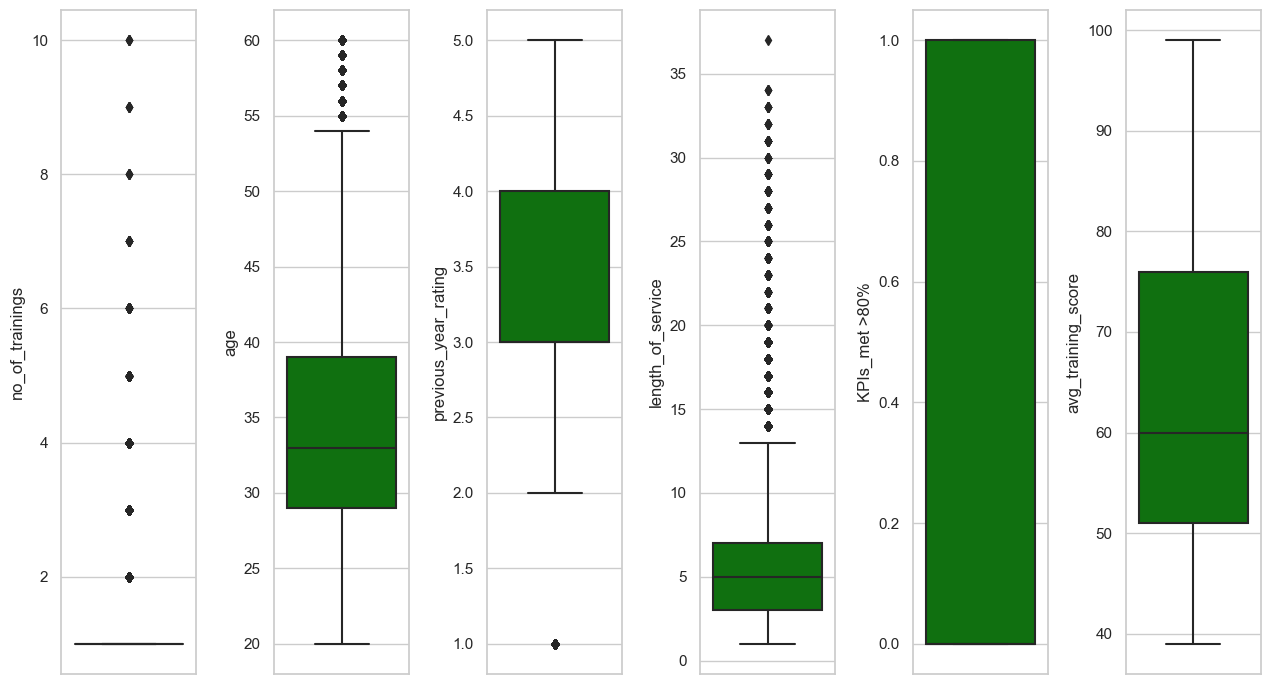

In [627]:
features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','avg_training_score']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=df[features[i]],color='green',)
    plt.tight_layout()

### DATA VISUALIZATION

In [628]:
#Let's look at the distributions of promoted employees based on age.

In [629]:
title = '''
Distribution of Promoted Employees based on age
'''
fig = px.histogram(df, x="age", title = title,
                   color = "is_promoted", 
                   labels= {"age":"Age","is_promoted": "Promoted"},
                   nbins=35,
                   color_discrete_sequence=px.colors.qualitative.Pastel1
                  )

fig.update_layout(
    autosize=False,
    width=900,
    height=650)
fig.show()

In [630]:
print("The average age of the employees is " + str(round(np.mean(df.age),0)))
print("The median age of the employees is " + str(np.median(df.age)))

The average age of the employees is 35.0
The median age of the employees is 33.0


In [631]:
#Let's look at the probabilty of promoted employees based on KPI.

In [632]:
df["KPIs_met >80%"].unique(), df["is_promoted"].unique()

(array([1, 0], dtype=int64), array([0, 1], dtype=int64))

In [633]:
probability_kpi = df.groupby(['KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
kpi = probability_kpi.pivot_table(index='KPIs_met >80%', columns='is_promoted', values='employee_id').reset_index()
kpi.columns = ['kpi', 'not_promoted', 'promoted']
kpi['total'] = kpi['not_promoted']+kpi['promoted']
kpi['probability'] = round((kpi['promoted']/kpi['total'])*100,2)
kpi = kpi.sort_values(['probability'], ascending=False)
kpi['kpi'] = kpi['kpi'].map({1: 'more than 80%', 0: "less than 80%"})
kpi


,kpi,not_promoted,promoted,total,probability
1,more than 80%,16029,3262,19291,16.91
0,less than 80%,34111,1406,35517,3.96


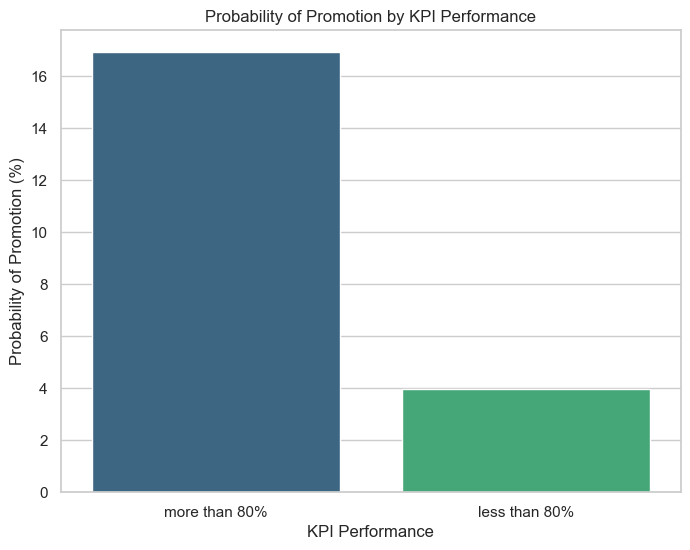

In [634]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='kpi', y='probability', data=kpi, palette='viridis')
plt.title('Probability of Promotion by KPI Performance')
plt.xlabel('KPI Performance')
plt.ylabel('Probability of Promotion (%)')
plt.show()

In [635]:
'''Employees who achieve KPIs of 
more than 80% have a 16.91% 
chance of getting a promotion'''

'Employees who achieve KPIs of \nmore than 80% have a 16.91% \nchance of getting a promotion'

In [636]:
#See the correlation between features using correlation matrix

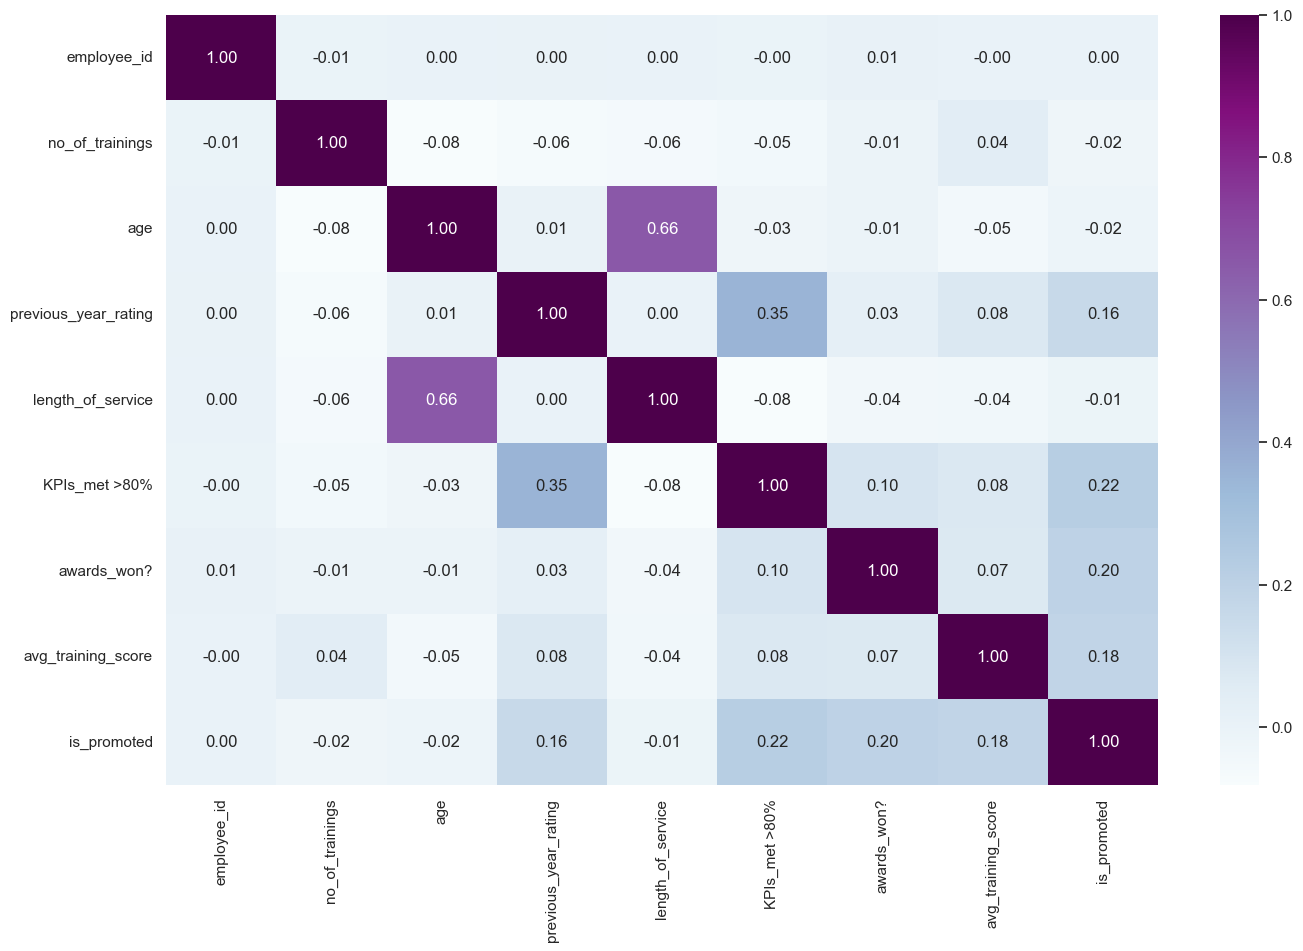

In [637]:

corr_= numerical.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu");

In [638]:
## Probability to Get Promotion based on region

In [639]:
region_probability = df.groupby(['region', 'is_promoted']).agg({'department': ['count']}).reset_index()
region_probability.columns = ['region', 'is_promoted','employees']
region_probability = pd.pivot_table(region_probability,
                             index = 'region',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

region_probability.columns = ['region','not_promoted','promoted']
region_probability['promotion_probs'] = (region_probability['promoted']/(region_probability['not_promoted']+region_probability['promoted']))*100
region_probability = region_probability.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
top_10_regions = region_probability.nlargest(10, 'promotion_probs')

top_10_regions

,region,not_promoted,promoted,promotion_probs
0,region_4,1457,246,14.445097
1,region_17,687,109,13.693467
2,region_25,716,103,12.576313
3,region_28,1164,154,11.684370
4,region_23,1038,137,11.659574
5,region_22,5694,734,11.418793
6,region_3,309,37,10.693642
7,region_7,4327,516,10.654553
8,region_1,552,58,9.508197
9,region_30,598,59,8.980213


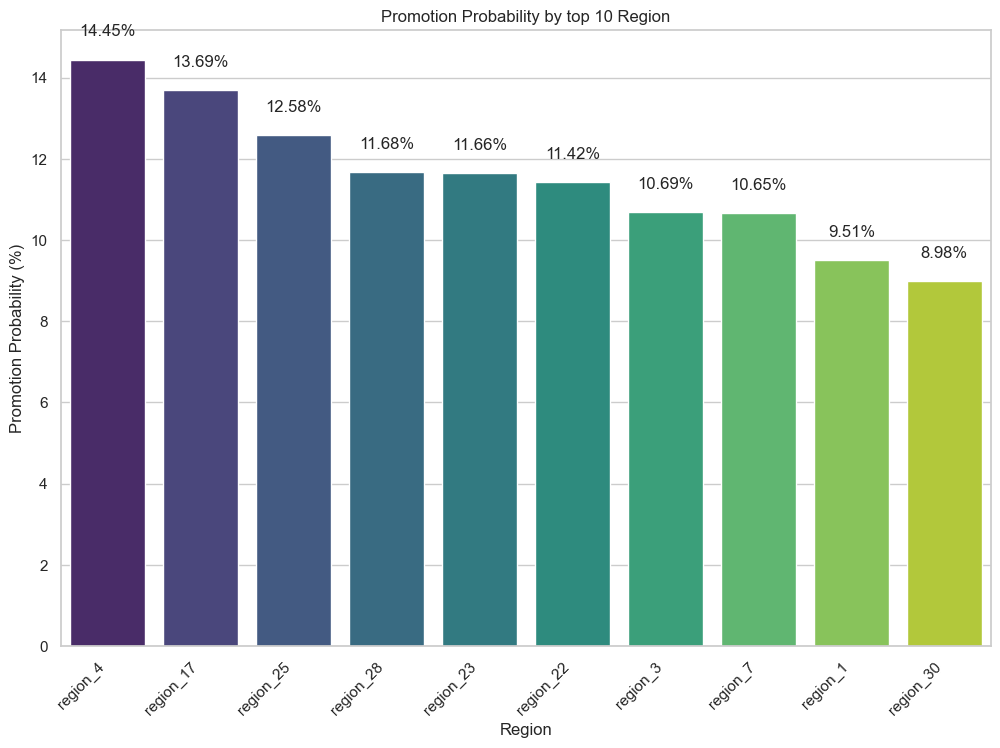

In [640]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='region', y='promotion_probs', data=top_10_regions, palette='viridis')
plt.title('Promotion Probability by top 10 Region')
plt.xlabel('Region')
plt.ylabel('Promotion Probability (%)')
plt.xticks(rotation=45, ha='right')
for bar in bar_plot.patches:
    # Calculate the height of the bar
    height = bar.get_height()
    
    # Annotate the bar with its height (promotion probability) formatted to 2 decimal places
    bar_plot.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')
plt.show()

In [641]:
'''
Based on region, employees who have a large enough
opportunity compared to employees in regions 4, 17, 25, 28, 23, 22, 3, 7 
(probability > 10%)
'''

'\nBased on region, employees who have a large enough\nopportunity compared to employees in regions 4, 17, 25, 28, 23, 22, 3, 7 \n(probability > 10%)\n'

In [642]:
# Probability to Get Promotion based on education

In [643]:
prob_edu = df.groupby(['education','is_promoted'])['employee_id'].count().reset_index()
edu = prob_edu.pivot_table(index='education', columns='is_promoted',  values='employee_id').reset_index()
edu.columns = ['education', 'not_promoted', 'promoted']
edu['total'] = edu['not_promoted']+edu['promoted']
edu['probability'] = round((edu['promoted']/edu['total'])*100,2)
edu = edu.sort_values(['probability'], ascending=False).reset_index(drop=True)
edu

,education,not_promoted,promoted,total,probability
0,Master's & above,13454,1471,14925,9.86
1,Below Secondary,738,67,805,8.32
2,Bachelor's,33661,3008,36669,8.20


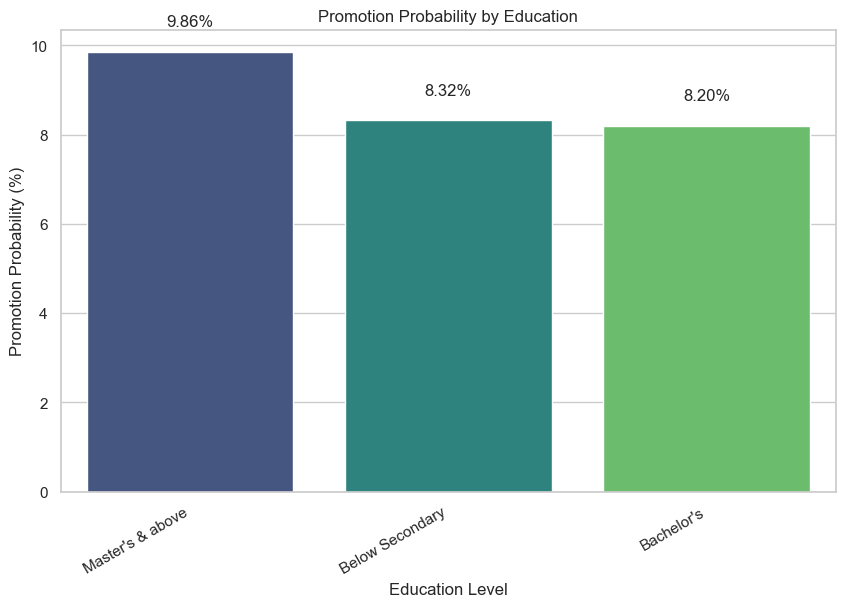

In [644]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='education', y='probability', data=edu, palette='viridis')
plt.title('Promotion Probability by Education')
plt.xlabel('Education Level')
plt.ylabel('Promotion Probability (%)')
plt.xticks(rotation=30, ha='right')
for bar in bar_plot.patches:
    # Calculate the height of the bar
    height = bar.get_height()
    
    # Annotate the bar with its height (promotion probability) formatted to 2 decimal places
    bar_plot.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')
plt.show()

In [645]:
'''
Employees with a master's education level
and above have a chance to be promoted by 9.86%
'''

"\nEmployees with a master's education level\nand above have a chance to be promoted by 9.86%\n"

In [646]:
# Probability to Get Promotion based on gender

In [647]:
prob_gender = df.groupby(['gender','is_promoted'])['employee_id'].count().reset_index()
gender = prob_gender.pivot_table(index='gender', columns='is_promoted', values='employee_id').reset_index()
gender.columns = ['gender', 'not_promoted', 'promoted']
gender['total'] = gender['not_promoted']+gender['promoted']
gender['probability'] = round((gender['promoted']/gender['total'])*100,2)
gender = gender.sort_values(['probability'], ascending=False).reset_index(drop=True)
gender

,gender,not_promoted,promoted,total,probability
0,f,14845,1467,16312,8.99
1,m,35295,3201,38496,8.32


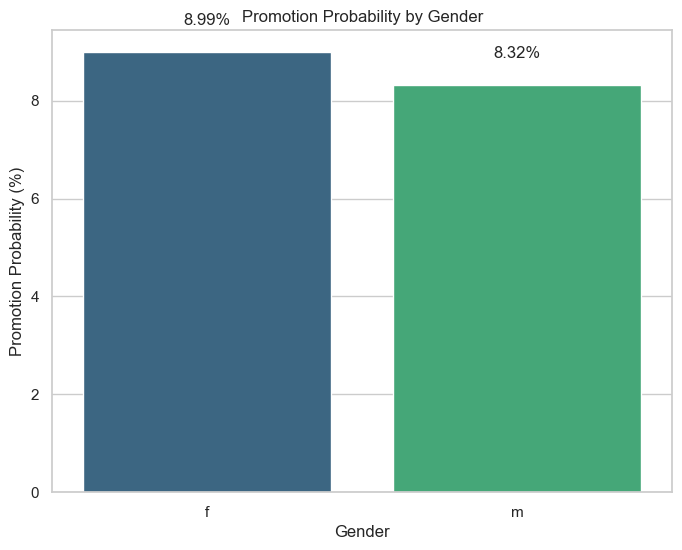

In [648]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='gender', y='probability', data=gender, palette='viridis')
plt.title('Promotion Probability by Gender')
plt.xlabel('Gender')
plt.ylabel('Promotion Probability (%)')
for bar in bar_plot.patches:
    # Calculate the height of the bar
    height = bar.get_height()
    bar_plot.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')
plt.show()


In [649]:
'''
8.99% of female employees are likely to be promoted
'''

'\n8.99% of female employees are likely to be promoted\n'

### PREPROCESSING

In [650]:
'''employeeid is not useful for our analysis since it is unique for each employee'''
df.drop("employee_id", axis=1, inplace=True)

### null handling

In [651]:
df.education.value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [652]:
df.previous_year_rating.value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [653]:
edu_null=df[df["education"].isnull()]
edu_notna=df[df["education"].notnull()]

edu_null.shape, edu_notna.shape

((2409, 13), (52399, 13))

In [654]:
edu_null.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
21,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,0,57,0
32,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,0,48,0
43,Sales & Marketing,region_2,NaN,m,other,3,24,2.0,2,0,0,48,0
82,Sales & Marketing,region_2,NaN,m,sourcing,2,25,3.0,2,0,0,53,0


In [655]:
edu_notna.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [656]:
edu_notna.education.value_counts()  #Bachelor's has more frequency

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [657]:
edu_null.department.value_counts()

Sales & Marketing    1575
Analytics             337
Operations            226
Technology             99
Procurement            72
Finance                36
HR                     32
R&D                    28
Legal                   4
Name: department, dtype: int64

In [658]:
edu_notna.department.value_counts()  #sales and marketing has more frequency

Sales & Marketing    15265
Operations           11122
Procurement           7066
Technology            7039
Analytics             5015
Finance               2500
HR                    2386
Legal                 1035
R&D                    971
Name: department, dtype: int64

In [659]:
df__=edu_notna[edu_notna["department"] == "Sales & Marketing"]
df__.education.value_counts()   #Bachelor's has more frequency when compared with department feature

Bachelor's          11099
Master's & above     4166
Name: education, dtype: int64

In [660]:
edu_null.region.value_counts()

region_2     846
region_22    320
region_7     219
region_15    191
region_26    100
region_31     94
region_27     84
region_28     84
region_32     84
region_13     56
region_16     55
region_9      48
region_25     34
region_23     28
region_11     24
region_14     23
region_29     19
region_1      14
region_6      14
region_30     13
region_8      13
region_19     10
region_17      9
region_21      8
region_5       7
region_10      4
region_3       2
region_4       2
region_12      2
region_20      1
region_24      1
Name: region, dtype: int64

In [661]:
edu_notna.region.value_counts()  #region_2 has more frequency

region_2     11497
region_22     6108
region_7      4624
region_15     2617
region_13     2592
region_26     2160
region_31     1841
region_4      1701
region_27     1575
region_16     1410
region_11     1291
region_28     1234
region_23     1147
region_29      975
region_19      864
region_32      861
region_20      849
region_14      804
region_17      787
region_25      785
region_5       759
region_6       676
region_10      644
region_30      644
region_8       642
region_1       596
region_24      507
region_12      498
region_21      403
region_9       372
region_3       344
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [662]:
edu_notna[(edu_notna["region"] == "region_2") & (edu_notna["department"] == "Sales & Marketing")].education.value_counts()

Bachelor's          1895
Master's & above     959
Name: education, dtype: int64

In [663]:
#on the whole when compared with two categories, Bachelor's is more preferred to fill missing values in education column

In [664]:
df.education.fillna("Bachelor's", inplace = True)
df.isnull().sum()

department                 0
region                     0
education                  0
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [665]:
df.previous_year_rating.value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [666]:
rating_null=df[df["previous_year_rating"].isnull()]
rating_notna=df[df["previous_year_rating"].notnull()]

In [667]:
rating_null.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,Technology,region_23,Bachelor's,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0


In [668]:
rating_notna.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [669]:
rating_notna.previous_year_rating.value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [670]:
rating_notna.department.value_counts()

Sales & Marketing    15529
Operations           10760
Procurement           6709
Technology            6592
Analytics             4886
Finance               2253
HR                    2172
R&D                    912
Legal                  871
Name: department, dtype: int64

In [671]:
rating_notna.no_of_trainings.value_counts()

1     41160
2      7324
3      1614
4       411
5       119
6        34
7        10
10        5
8         4
9         3
Name: no_of_trainings, dtype: int64

In [672]:
rating_notna["awards_won?"].value_counts()

0    49510
1     1174
Name: awards_won?, dtype: int64

In [673]:
df_=rating_notna[rating_notna["no_of_trainings"] == 1]
df_.previous_year_rating.value_counts()

3.0    14584
5.0     9904
4.0     8300
1.0     4864
2.0     3508
Name: previous_year_rating, dtype: int64

In [674]:
rating_notna[(rating_notna["no_of_trainings"] == 1) & (rating_notna["awards_won?"] ==0)].previous_year_rating.value_counts()

3.0    14267
5.0     9593
4.0     8104
1.0     4778
2.0     3441
Name: previous_year_rating, dtype: int64

In [675]:
df.previous_year_rating.fillna(3.0, inplace = True) #since 3.0 is the most preferred rating

In [676]:
df.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

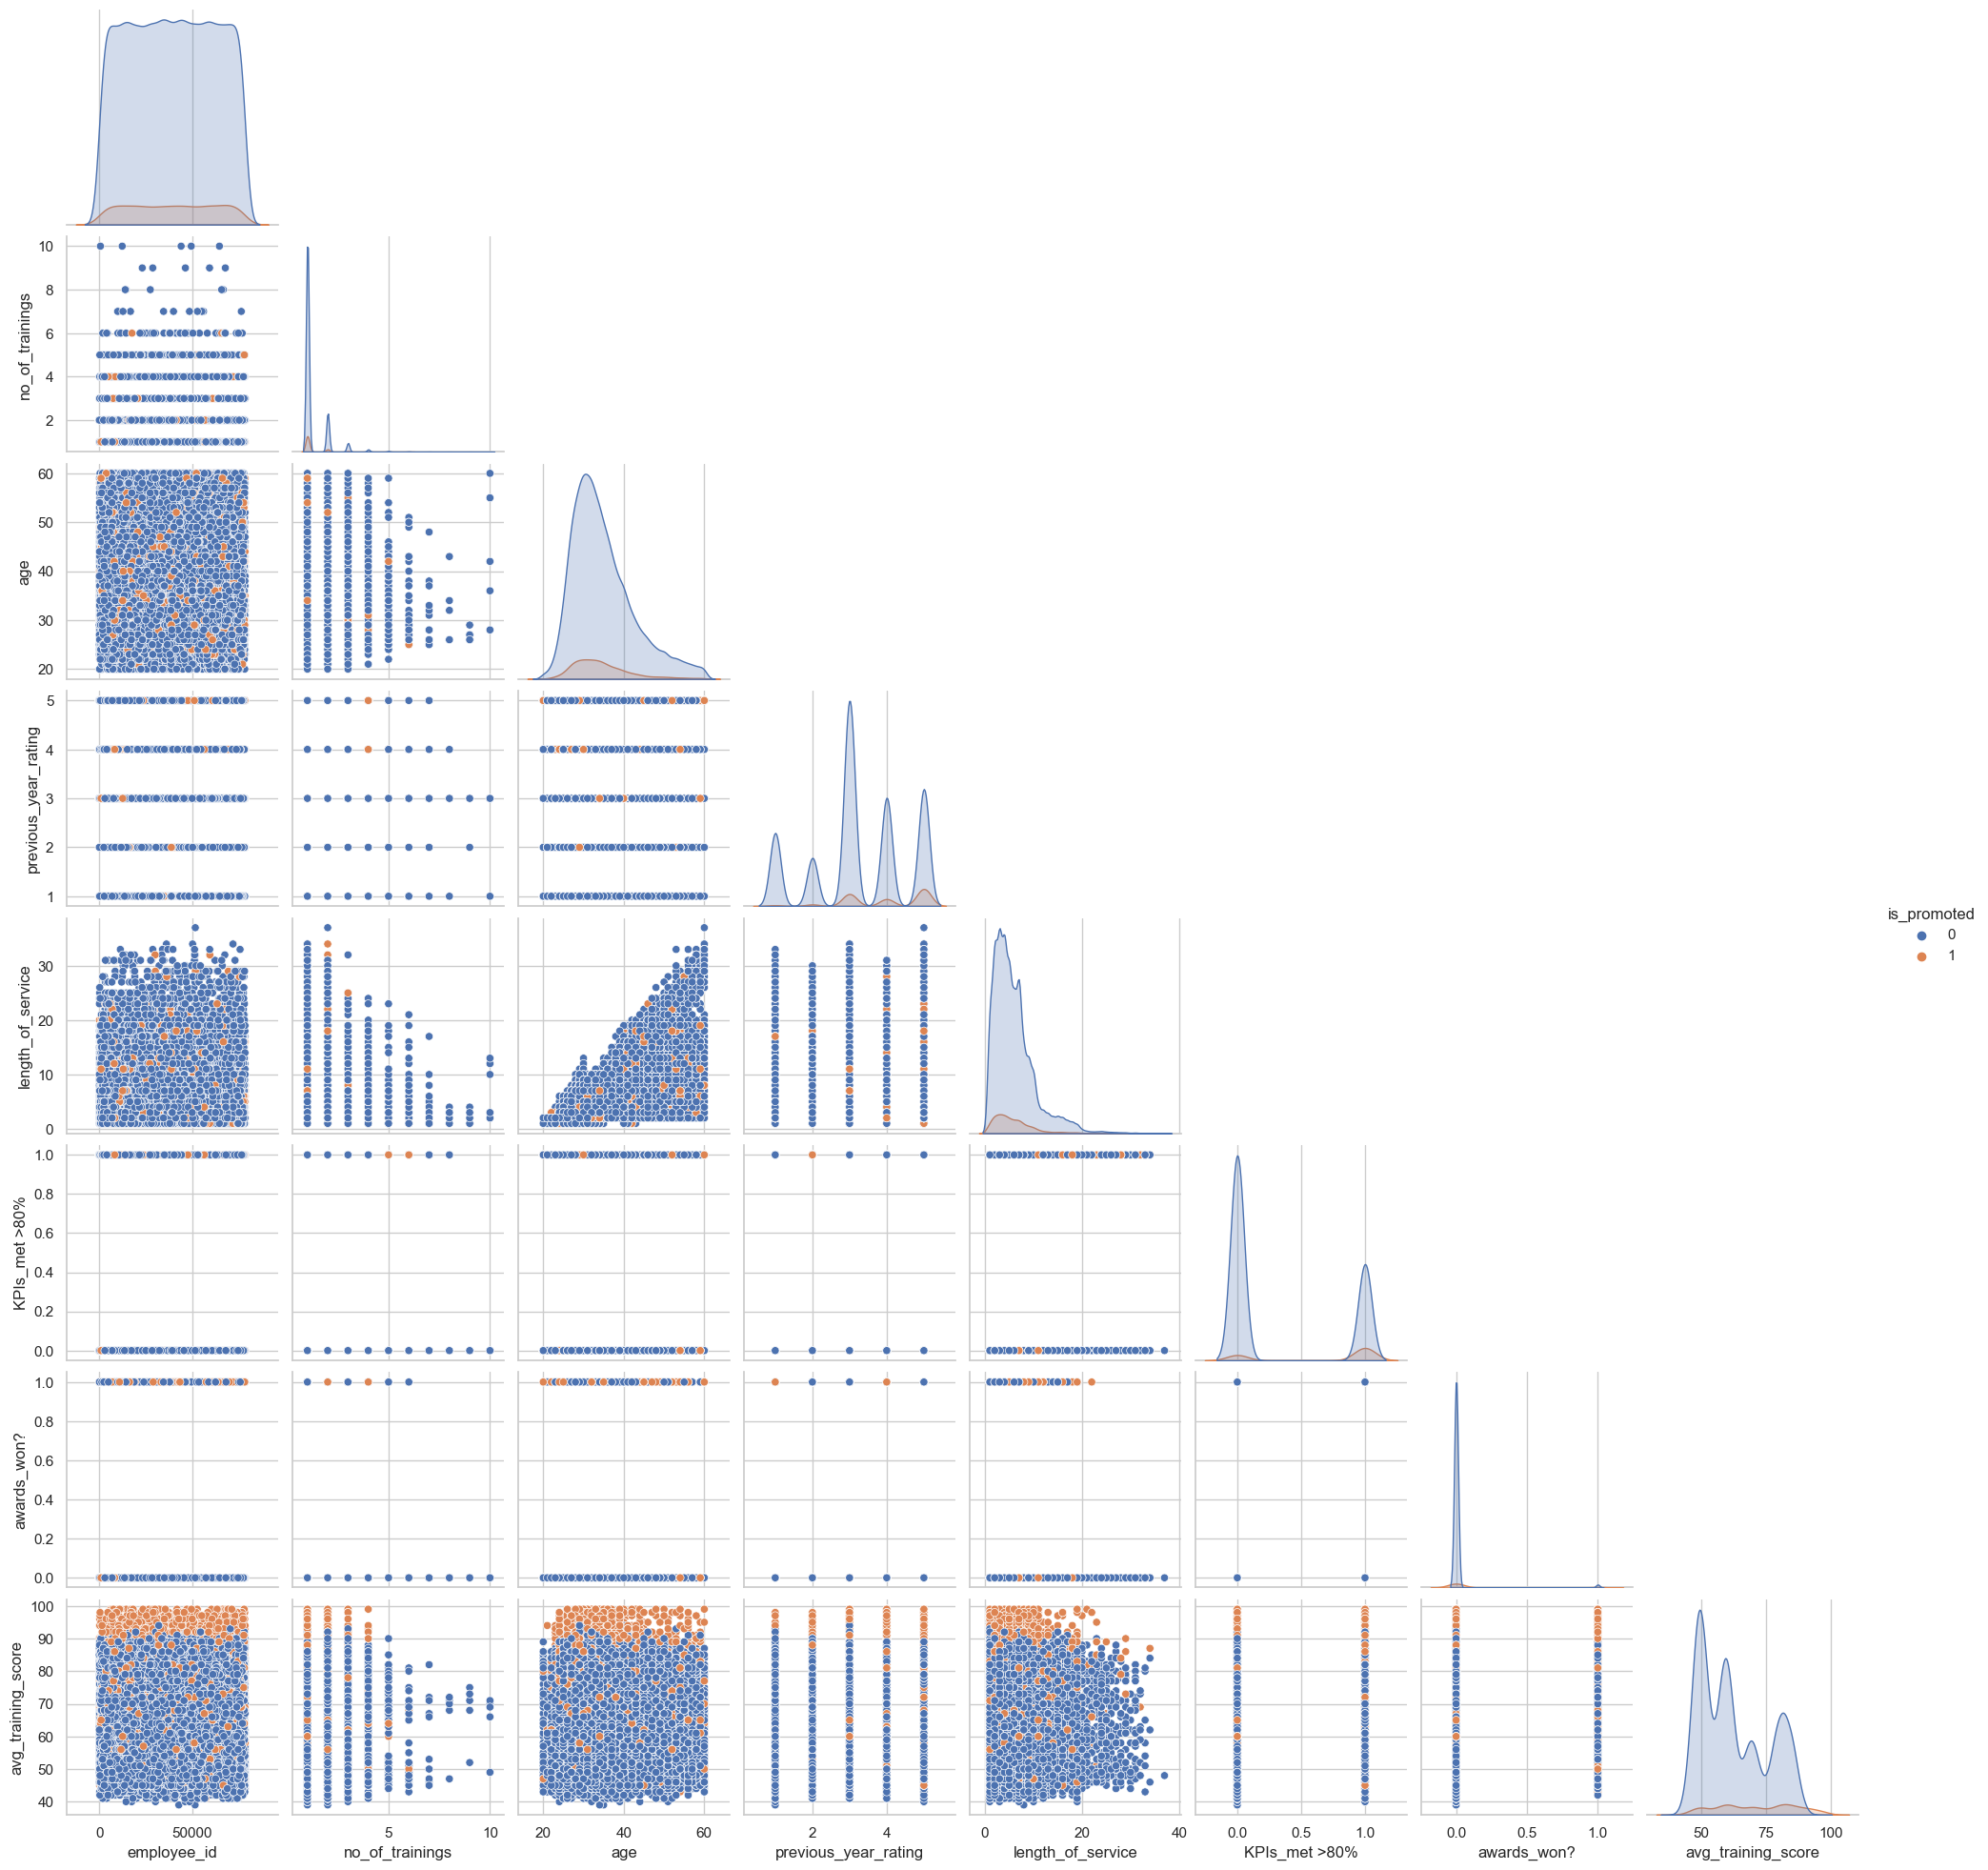

In [677]:
sns.pairplot(numerical, hue= 'is_promoted', corner=True)

### Outlier check

In [678]:
df["awards_won?"].value_counts()

0    53538
1     1270
Name: awards_won?, dtype: int64

In [679]:
df["KPIs_met >80%"].value_counts()

0    35517
1    19291
Name: KPIs_met >80%, dtype: int64

In [680]:
'''in this dataset outliers are not treated as outliers because they cant be removed from the dataset, only removing one outlier from 
the length of service column affects the skewness of the data'''

'in this dataset outliers are not treated as outliers because they cant be removed from the dataset, only removing one outlier from \nthe length of service column affects the skewness of the data'

### Skew check

skewness of age 1.0074317710382241


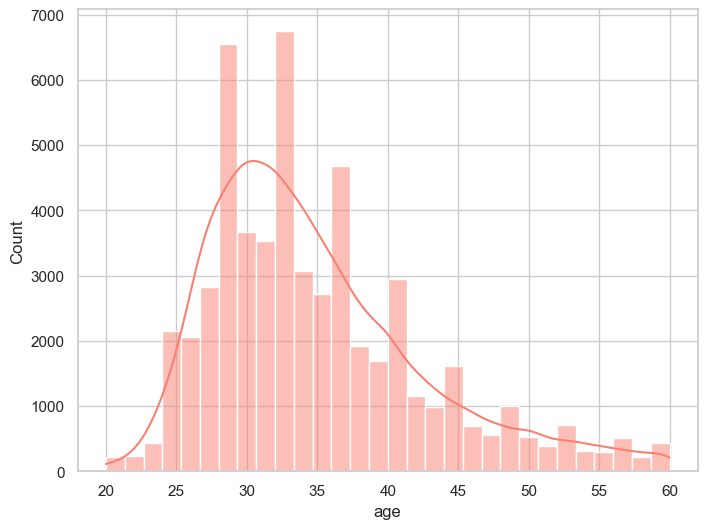

skewness of length_of_service 1.738061458740809


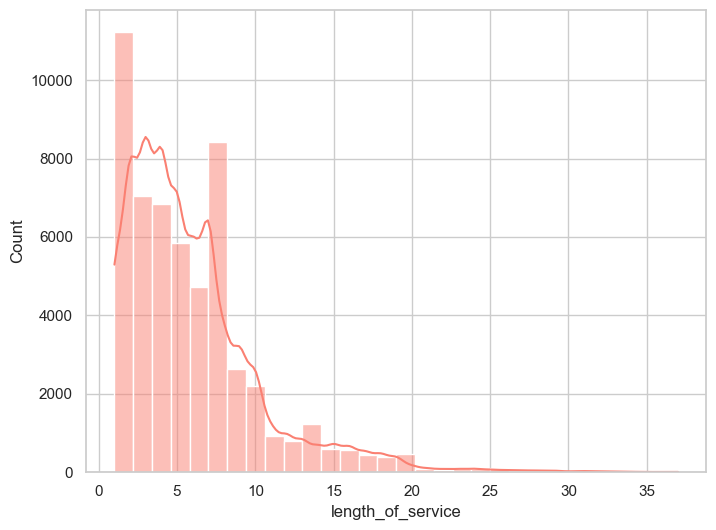

skewness of avg_training_score 0.45190808551707995


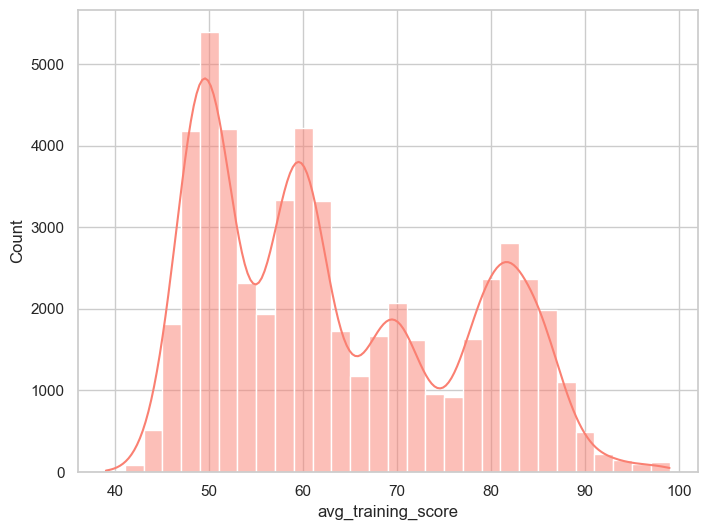

In [681]:
features = ['age','length_of_service','avg_training_score']

for i in range(0, len(features)):
    plt.figure(figsize=(8, 6))
    print("skewness of",features[i],df[features[i]].skew())
    sns.histplot(df, x= df[features[i]], kde= True, bins=30,color="salmon")
    plt.show()

In [682]:
'''
from the skewness we can see that length_of_service is not normally distributed, when one outlier is removed so keeping it as it is
'''

'\nfrom the skewness we can see that length_of_service is not normally distributed, when one outlier is removed so keeping it as it is\n'

In [683]:
features = ['age','length_of_service','avg_training_score']

for i in range(0, len(features)):
    print("skewness of",features[i],df[features[i]].skew())
    print("Log skewed of",features[i],np.log(df[features[i]]).skew())
    print("sqrt skewed of",features[i],np.sqrt(df[features[i]]).skew())
    print("\n")

skewness of age 1.0074317710382241
Log skewed of age 0.48230408268904185
sqrt skewed of age 0.743484663450539


skewness of length_of_service 1.738061458740809
Log skewed of length_of_service -0.28990179567467633
sqrt skewed of length_of_service 0.6595314372339438


skewness of avg_training_score 0.45190808551707995
Log skewed of avg_training_score 0.2220235749973284
sqrt skewed of avg_training_score 0.33753162715401824




In [684]:
#deciding which to get log or sqrt transformation
df["age"] = np.log(df["age"])
df["length_of_service"] = np.log(df["length_of_service"])


skewness of age 0.48230408268904185


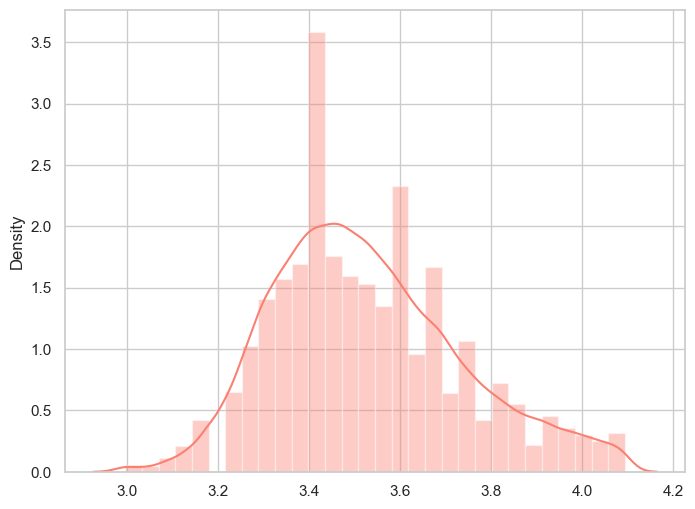

skewness of length_of_service -0.28990179567467633


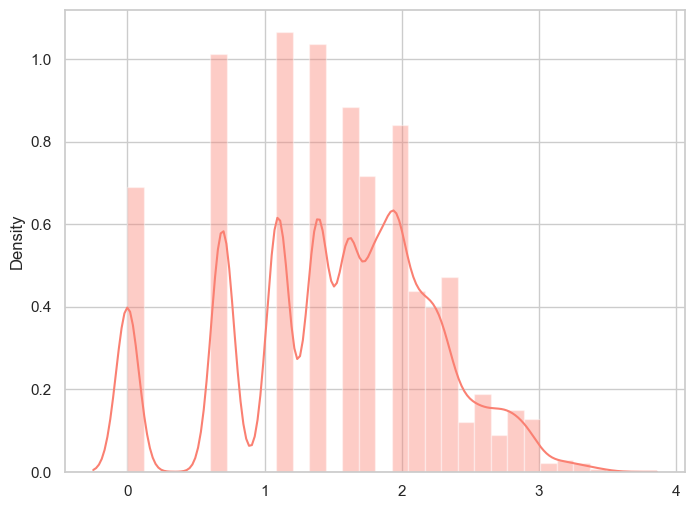

skewness of avg_training_score 0.45190808551707995


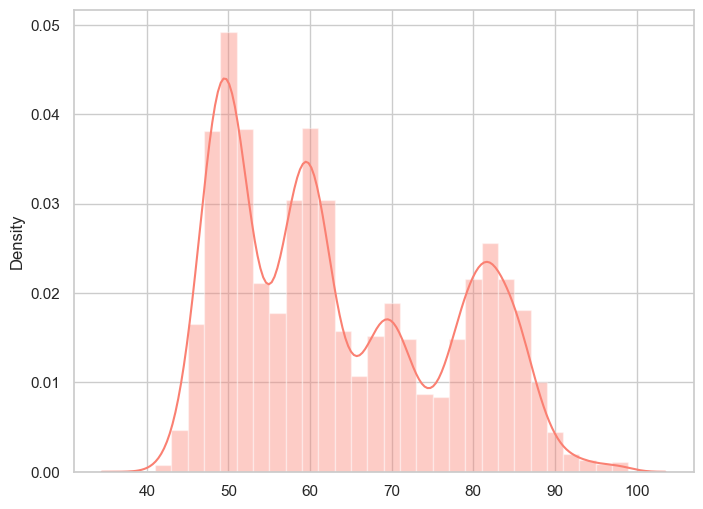

In [685]:
features = ['age','length_of_service','avg_training_score']

for i in range(0, len(features)):
    plt.figure(figsize=(8, 6))
    print("skewness of",features[i],df[features[i]].skew())
    sns.distplot(df, x= df[features[i]], kde= True,bins=30,color="salmon")
    plt.show()

In [686]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,3.555348,5.0,2.079442,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,3.401197,5.0,1.386294,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,3.526361,3.0,1.945910,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,3.663562,1.0,2.302585,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,3.806662,3.0,0.693147,0,0,73,0


### Feature engineering

In [687]:
num= df.select_dtypes(exclude="object")
num

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1,3.555348,5.0,2.079442,1,0,49,0
1,1,3.401197,5.0,1.386294,0,0,60,0
2,1,3.526361,3.0,1.945910,0,0,50,0
3,2,3.663562,1.0,2.302585,0,0,50,0
4,1,3.806662,3.0,0.693147,0,0,73,0
...,...,...,...,...,...,...,...,...
54803,1,3.871201,3.0,2.833213,0,0,78,0
54804,1,3.610918,2.0,1.791759,0,0,56,0
54805,1,3.295837,5.0,1.098612,1,0,79,0
54806,1,3.367296,1.0,0.693147,0,0,45,0


In [688]:
cat= df.select_dtypes(include="object")
cat.head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


In [689]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform="pandas")
encoder.fit_transform(cat)

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
54804,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
54805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
54806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [690]:
df_final=pd.concat([num,encoder.fit_transform(cat)],axis=1)
df_final

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,1,3.555348,5.0,2.079442,1,0,49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1,3.401197,5.0,1.386294,0,0,60,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,3.526361,3.0,1.945910,0,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2,3.663562,1.0,2.302585,0,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,3.806662,3.0,0.693147,0,0,73,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,1,3.871201,3.0,2.833213,0,0,78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
54804,1,3.610918,2.0,1.791759,0,0,56,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
54805,1,3.295837,5.0,1.098612,1,0,79,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
54806,1,3.367296,1.0,0.693147,0,0,45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [691]:
df_final.isna().sum()

no_of_trainings                 0
age                             0
previous_year_rating            0
length_of_service               0
KPIs_met >80%                   0
awards_won?                     0
avg_training_score              0
is_promoted                     0
department_Analytics            0
department_Finance              0
department_HR                   0
department_Legal                0
department_Operations           0
department_Procurement          0
department_R&D                  0
department_Sales & Marketing    0
department_Technology           0
region_region_1                 0
region_region_10                0
region_region_11                0
region_region_12                0
region_region_13                0
region_region_14                0
region_region_15                0
region_region_16                0
region_region_17                0
region_region_18                0
region_region_19                0
region_region_2                 0
region_region_

In [692]:
df_final.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [693]:
#imbalance in data so using smote algo for balancing

X_0=df_final[df_final["is_promoted"]==0].sample(15000)#15k

X_1=df_final[df_final["is_promoted"]==1]#ALL#4668

X=pd.concat([X_0,X_1],axis=0).drop("is_promoted",axis=1) #is_promoted    #19668

y=pd.concat([X_0,X_1],axis=0).is_promoted

In [694]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 15000, 1: 15000})


In [695]:
X_res.shape,y_res.shape

((30000, 58), (30000,))

### Feature importance using RF

In [696]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_res,y_res,test_size=0.2, random_state=42)


In [697]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [698]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state=42)
rf_model = rf.fit(xtrain, ytrain)

In [699]:
importances = rf.feature_importances_
importances

array([1.81712611e-02, 8.74838027e-02, 1.03054529e-01, 7.73116910e-02,
       1.15830366e-01, 1.21390358e-02, 1.91572284e-01, 1.17375079e-02,
       7.52633537e-03, 5.83606335e-03, 3.90018300e-03, 1.77895082e-02,
       1.25422482e-02, 4.88543854e-03, 3.22017199e-02, 1.22968032e-02,
       2.93952653e-03, 2.02573941e-03, 5.93831414e-03, 1.78436308e-03,
       1.00958779e-02, 3.64489645e-03, 8.53821471e-03, 4.40313415e-03,
       4.44515790e-03, 6.17568648e-05, 3.06951590e-03, 2.87966055e-02,
       2.91163802e-03, 1.51638866e-03, 2.92673397e-02, 5.35240137e-03,
       1.31590025e-03, 4.32346403e-03, 7.29937557e-03, 5.80520627e-03,
       7.12429134e-03, 3.59381298e-03, 1.34398180e-03, 2.04521778e-03,
       6.33701955e-03, 3.10077609e-03, 8.26771729e-04, 6.11910438e-04,
       1.28316646e-02, 2.51856134e-03, 2.35694052e-03, 1.75320003e-02,
       2.80730208e-03, 8.63006166e-04, 1.29568446e-02, 1.87685598e-03,
       1.21921133e-02, 1.31591929e-02, 1.26681973e-02, 1.53468494e-02,
      

In [700]:
pd.DataFrame(importances).sort_values(ascending=False,by=0).index[0:5]

Int64Index([6, 4, 2, 1, 3], dtype='int64')

In [701]:
X_res.columns[pd.DataFrame(importances).sort_values(ascending=False,by=0).index[0:5]]

Index(['avg_training_score', 'KPIs_met >80%', 'previous_year_rating', 'age',
       'length_of_service'],
      dtype='object')

<Figure size 1800x1800 with 0 Axes>

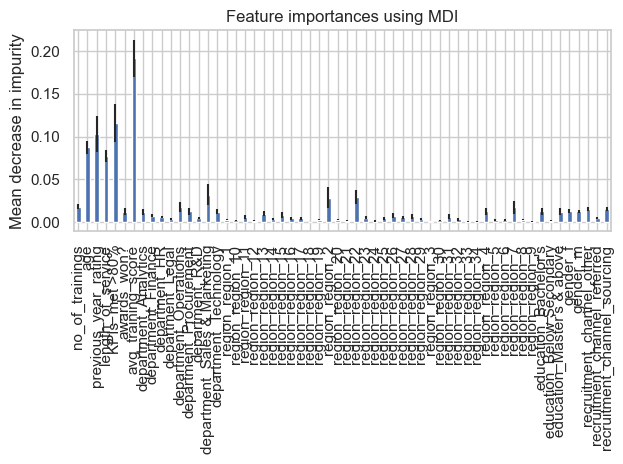

In [702]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_res.columns)
plt.figure(figsize=(18,18))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## MODELING DATA 

### Random Forest

In [703]:
#using Random Forest
y_predicted_test = rf.predict(xtest)
y_predicted_train = rf.predict(xtrain)


In [704]:
#evalation
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)


classification report
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3048
           1       0.89      0.90      0.89      2952

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000


accuracy test
0.896

accuracy train
0.9999166666666667


array([[2725,  323],
       [ 301, 2651]], dtype=int64)

ROC AUC Score:  89.6 %


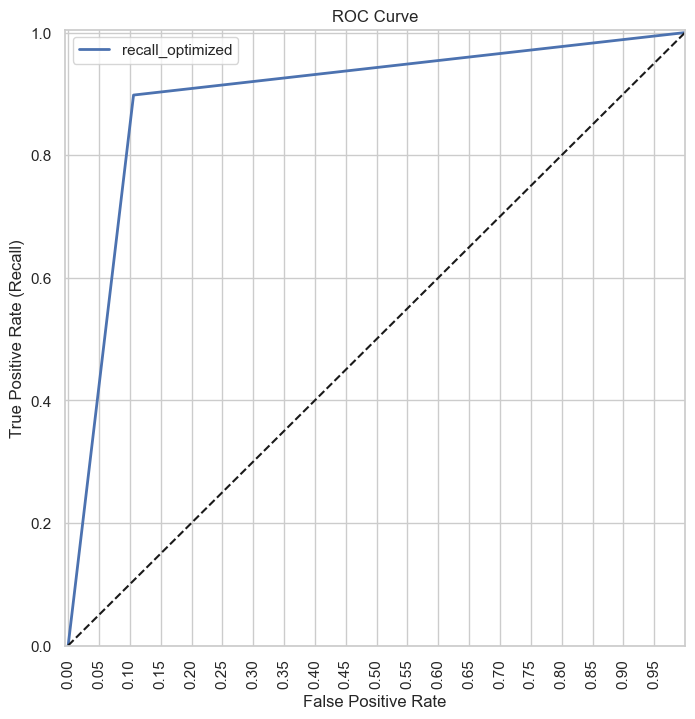

In [705]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted_test)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [706]:
#save model
import pickle
pickle.dump(rf_model, open('RandomForest.pkl', 'wb'))

In [707]:
#Load and print model score
loaded_model = pickle.load(open('RandomForest.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)  #test set score

0.896


In [708]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  99.99 %
test score :  89.6 %


### KNN

In [709]:
# using KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(xtrain, ytrain)
y_predicted_test = knn.predict(xtest)
y_predicted_train = knn.predict(xtrain)

In [710]:
print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)


classification report
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      3048
           1       0.73      0.82      0.77      2952

    accuracy                           0.76      6000
   macro avg       0.77      0.76      0.76      6000
weighted avg       0.77      0.76      0.76      6000


accuracy test
0.7631666666666667

accuracy train
0.852375


array([[2162,  886],
       [ 535, 2417]], dtype=int64)

ROC AUC Score:  76.4 %


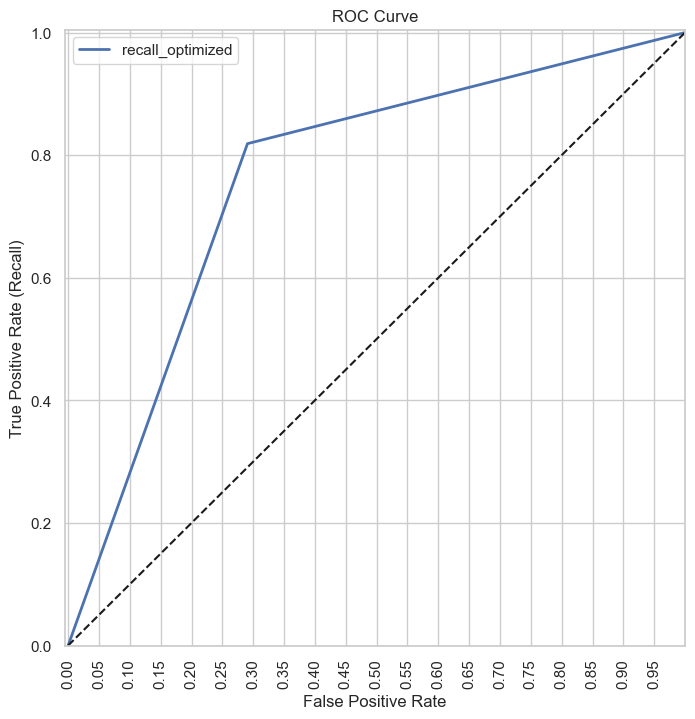

In [711]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted_test)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [712]:
#save model
import pickle
pickle.dump(knn_model, open('KNN.pkl', 'wb'))

In [713]:
#Load and print model score
loaded_model = pickle.load(open('KNN.pkl', 'rb'))

In [714]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  85.24 %
test score :  76.32 %


### Logistic Regression

In [715]:
# using Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(xtrain, ytrain)
y_predicted_test = lr.predict(xtest)
y_predicted_train = lr.predict(xtrain)


In [716]:
print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)


classification report
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      3048
           1       0.76      0.82      0.79      2952

    accuracy                           0.78      6000
   macro avg       0.79      0.78      0.78      6000
weighted avg       0.79      0.78      0.78      6000


accuracy test
0.7841666666666667

accuracy train
0.7875416666666667


array([[2286,  762],
       [ 533, 2419]], dtype=int64)

ROC AUC Score:  78.5 %


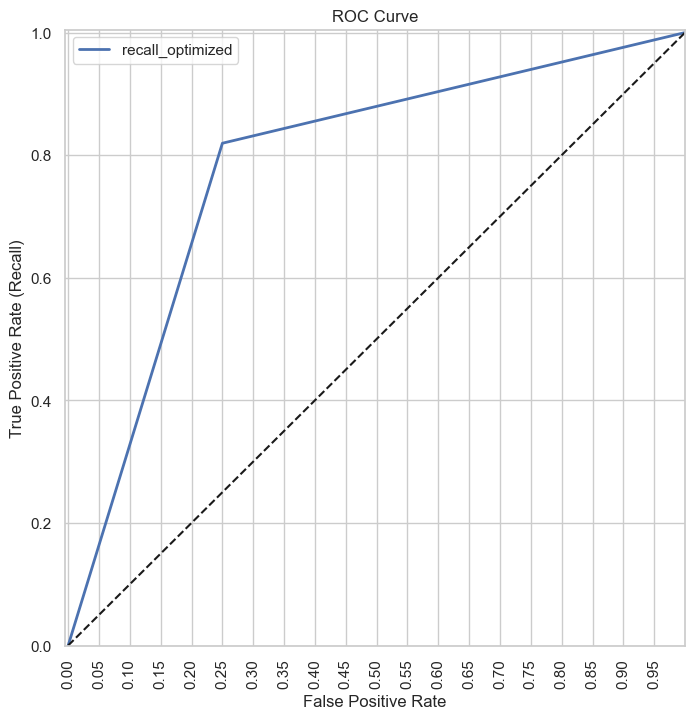

In [717]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted_test)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [718]:
#save model
import pickle
pickle.dump(lr_model, open('LogisticRegression.pkl', 'wb'))

In [719]:
#Load and print model score
loaded_model = pickle.load(open('LogisticRegression.pkl', 'rb'))

In [720]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  78.75 %
test score :  78.42 %


### Decision Tree

In [721]:
# USING Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(xtrain, ytrain)
y_predicted_test = dt.predict(xtest)
y_predicted_train = dt.predict(xtrain)

In [722]:
print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)


classification report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3048
           1       0.85      0.88      0.86      2952

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000


accuracy test
0.864

accuracy train
0.9999166666666667


array([[2593,  455],
       [ 361, 2591]], dtype=int64)

ROC AUC Score:  86.4 %


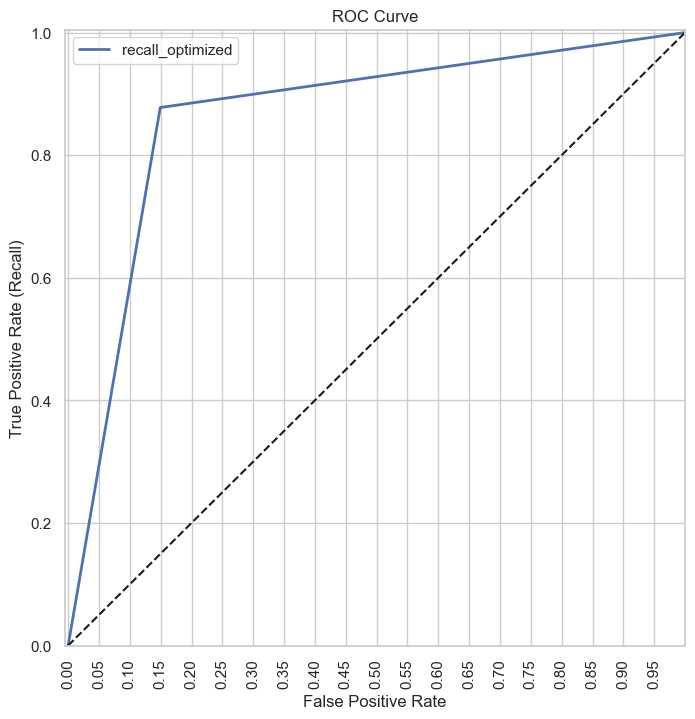

In [723]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted_test)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [724]:
#save model
import pickle
pickle.dump(dt_model, open('DecisionTree.pkl', 'wb'))

In [725]:
#Load and print model score
loaded_model = pickle.load(open('DecisionTree.pkl', 'rb'))

In [726]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  99.99 %
test score :  86.4 %


### XGBOOST

In [727]:
#using xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_model = xgb.fit(xtrain, ytrain)
y_predicted_test = xgb.predict(xtest)
y_predicted_train = xgb.predict(xtrain)

In [728]:
print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)


classification report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3048
           1       0.92      0.88      0.90      2952

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000


accuracy test
0.903

accuracy train
0.9360833333333334


array([[2814,  234],
       [ 348, 2604]], dtype=int64)

ROC AUC Score:  90.3 %


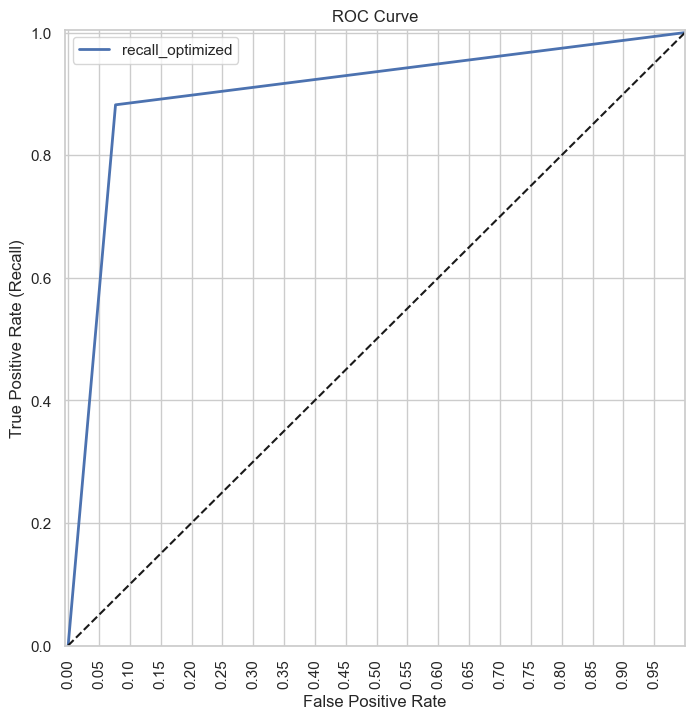

In [729]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted_test)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [730]:
#save model
import pickle
pickle.dump(xgb_model, open('XGBoost.pkl', 'wb'))

In [731]:
#Load and print model score
loaded_model = pickle.load(open('XGBoost.pkl', 'rb'))

In [732]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  93.61 %
test score :  90.3 %


## Hyperparameter tuning

In [733]:
# since xgboost is convincing model with great acc and roc auc, we will use xgboost.
#but i am interested in tuning random forest and decision tree as they are overfitting but gives best rou auc score

### Random forest and decision tree

In [734]:
from sklearn.model_selection import RandomizedSearchCV
hyperparameters = {
               'min_samples_split': [7,8,9,10],
               'min_samples_leaf': [1,2,3,4,5],
               'max_depth': [5,6,7,8,9,10],
               'max_features': ['auto', 'sqrt', 'log2'],
               'bootstrap': [True],
               'n_jobs':[-1]}

# Init random forest with randomsearch, cross validation = 5
rf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(rf, hyperparameters, cv=20, random_state=42)

#Fitting Model
best_model1 = clf.fit(xtrain,ytrain)

print('best parameters', best_model1.best_params_)

y_predicted_test = best_model1.predict(xtest)
y_predicted_train = best_model1.predict(xtrain)

print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)
print('roc_auc_score', roc_auc_score(ytest, y_predicted_test))

best parameters {'n_jobs': -1, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}

classification report
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      3048
           1       0.76      0.90      0.83      2952

    accuracy                           0.81      6000
   macro avg       0.82      0.82      0.81      6000
weighted avg       0.83      0.81      0.81      6000


accuracy test
0.8138333333333333

accuracy train
0.83275
roc_auc_score 0.815250037342893


### Decision Tree

In [735]:
hyperparameters = {
    'max_depth' : [int(x) for x in np.linspace(1, 110, num = 30)], # Maximum number of levels in tree
'min_samples_split' :[2, 5, 10, 100] ,# Minimum number of samples required to split a node
'min_samples_leaf' :[1, 2, 4, 10, 20, 50], # Minimum number of samples required at each leaf node
'max_features' : ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
'criterion' :['entropy', 'gini'],
'splitter' :['random']
}

# Init DT with Gridsearch, cross validation = 5
dt2 = DecisionTreeClassifier(random_state=42)
clf = RandomizedSearchCV(dt2, hyperparameters, cv=5, random_state=42)

#Fitting Model
best_model2 = clf.fit(xtrain, ytrain)

print('best parameters', best_model2.best_params_)

y_predicted_test = best_model2.predict(xtest)
y_predicted_train = best_model2.predict(xtrain)

print('\nclassification report')
print(classification_report(ytest, y_predicted_test))
print('\naccuracy test')
print(accuracy_score(ytest, y_predicted_test))
print('\naccuracy train')
print(accuracy_score(ytrain,y_predicted_train))
confusion_matrix(ytest, y_predicted_test)
print('roc_auc_score', roc_auc_score(ytest, y_predicted_test))

best parameters {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 38, 'criterion': 'entropy'}

classification report
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      3048
           1       0.80      0.74      0.77      2952

    accuracy                           0.78      6000
   macro avg       0.79      0.78      0.78      6000
weighted avg       0.79      0.78      0.78      6000


accuracy test
0.7838333333333334

accuracy train
0.8725416666666667
roc_auc_score 0.7831671574589761


## Prediction of  the test data

In [736]:
#finally we can use xgboost as it gives best roc auc score and accuracy

In [737]:
df_test=pd.read_csv("test.csv")

In [738]:
df_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [739]:
df_test.shape

(23490, 13)

## Preprocessing test data

In [740]:
df_test.isna().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [741]:
df_test.previous_year_rating.value_counts()

3.0    7921
5.0    5097
4.0    4249
1.0    2680
2.0    1731
Name: previous_year_rating, dtype: int64

In [742]:
df_test.education.value_counts()

Bachelor's          15578
Master's & above     6504
Below Secondary       374
Name: education, dtype: int64

In [743]:
df_test.education=df_test.education.fillna("Bachelor's")

In [744]:
prev_not_null=df_test[df_test['previous_year_rating'].notnull()]
prev_null=df_test[df_test['previous_year_rating'].isnull()]

col=['previous_year_rating','department','length_of_service']
for i in col:
    print(i)
    print(prev_not_null[i].value_counts())
    print("---"*10)
    

previous_year_rating
3.0    7921
5.0    5097
4.0    4249
1.0    2680
2.0    1731
Name: previous_year_rating, dtype: int64
------------------------------
department
Sales & Marketing    6711
Operations           4521
Procurement          2841
Technology           2766
Analytics            2084
Finance               988
HR                    983
R&D                   399
Legal                 385
Name: department, dtype: int64
------------------------------
length_of_service
3     3033
4     2911
2     2870
5     2592
7     2344
6     2038
8     1263
9     1070
10     941
11     352
12     328
13     271
14     261
15     240
16     212
17     204
1      180
18     166
19     142
20      62
23      31
21      29
22      27
25      24
24      18
27      16
26      14
28      12
29      10
31       7
30       6
34       2
33       1
32       1
Name: length_of_service, dtype: int64
------------------------------


In [745]:
prev_not_null[(prev_not_null["length_of_service"] == 3) & (prev_not_null["department"] =="Sales & Marketing")].previous_year_rating.value_counts()

3.0    303
5.0    196
4.0    184
1.0    179
2.0     97
Name: previous_year_rating, dtype: int64

In [746]:
df_test.previous_year_rating=df_test.previous_year_rating.fillna(3.0)

In [747]:
df_test.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

In [748]:
df_test_id=df_test.copy()

In [749]:
df_test.drop('employee_id',axis=1,inplace=True)

skewness of age 1.0117773507112382


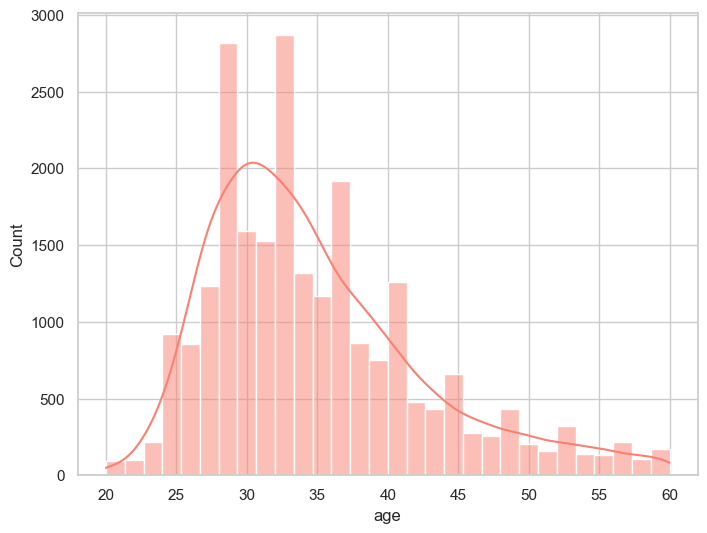

skewness of length_of_service 1.7030008581343499


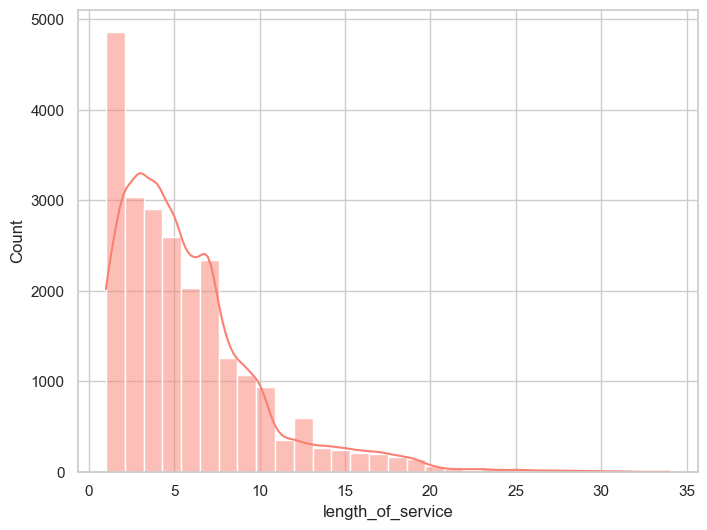

skewness of avg_training_score 0.4581131346053442


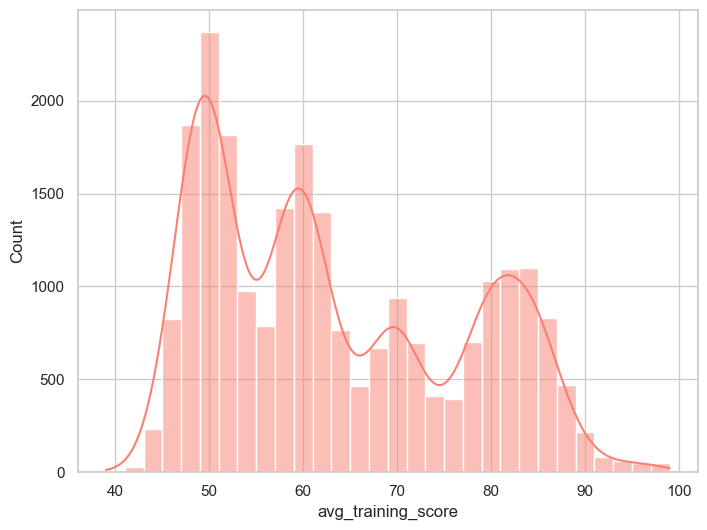

In [750]:
features = ['age','length_of_service','avg_training_score']
for i in range(0, len(features)):
    plt.figure(figsize=(8, 6))
    print("skewness of",features[i],df_test[features[i]].skew())
    sns.histplot(df_test, x= df_test[features[i]], kde= True, bins=30,color="salmon")
    plt.show()

    

In [751]:
#deciding which to get log or sqrt transformation
df_test["age"] = np.log(df_test["age"])
df_test["length_of_service"] = np.log(df_test["length_of_service"])

skewness of age 0.48662696355055707


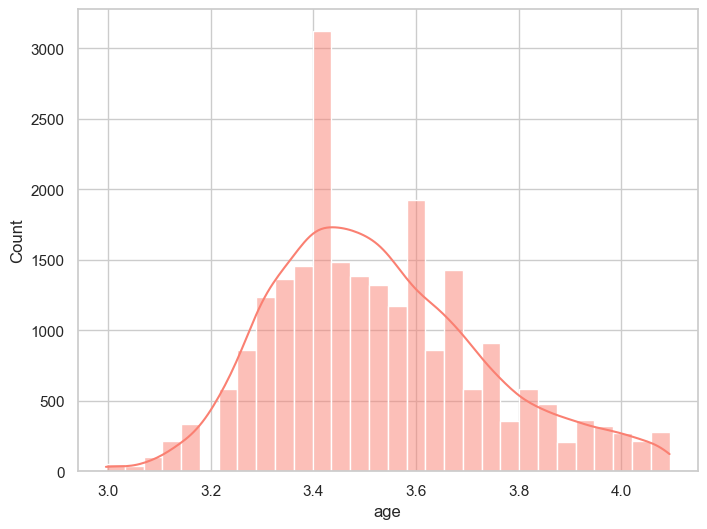

skewness of length_of_service -0.2930748215947123


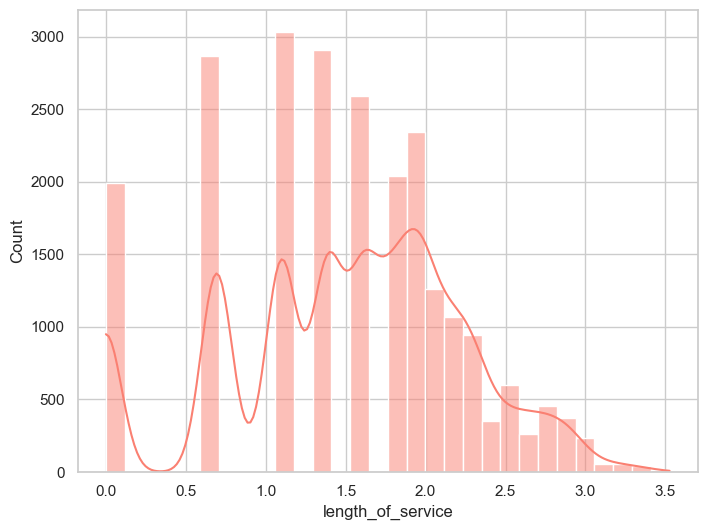

skewness of avg_training_score 0.4581131346053442


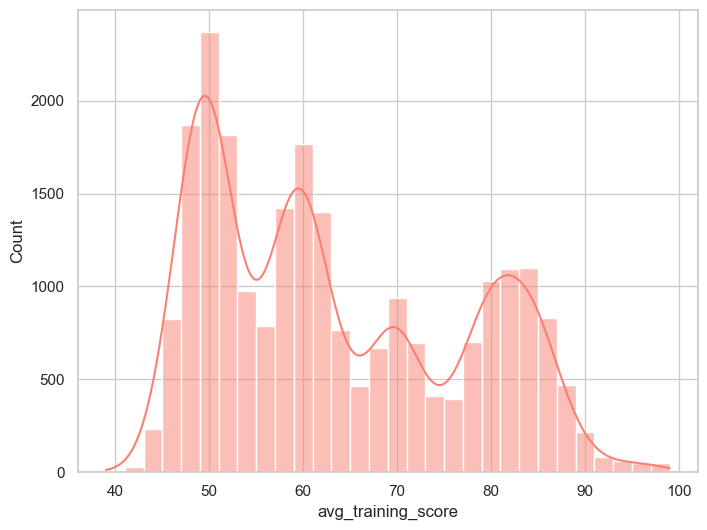

In [752]:
features = ['age','length_of_service','avg_training_score']
for i in range(0, len(features)):
    plt.figure(figsize=(8, 6))
    print("skewness of",features[i],df_test[features[i]].skew())
    sns.histplot(df_test, x= df_test[features[i]], kde= True, bins=30,color="salmon")
    plt.show()

    

In [753]:
df_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Technology,region_26,Bachelor's,m,sourcing,1,3.178054,3.0,0.000000,1,0,77
1,HR,region_4,Bachelor's,f,other,1,3.433987,3.0,1.609438,0,0,51
2,Sales & Marketing,region_13,Bachelor's,m,other,1,3.433987,1.0,1.386294,0,0,47
3,Procurement,region_2,Bachelor's,f,other,3,3.433987,2.0,2.197225,0,0,65
4,Finance,region_29,Bachelor's,m,sourcing,1,3.401197,4.0,1.945910,0,0,61


In [754]:
num= df_test.select_dtypes(exclude="object")
cat= df_test.select_dtypes(include="object")

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform="pandas")
encoder.fit_transform(cat)
df_final_test=pd.concat([num,encoder.fit_transform(cat)],axis=1)
df_final_test

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,1,3.178054,3.0,0.000000,1,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,3.433987,3.0,1.609438,0,0,51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,3.433987,1.0,1.386294,0,0,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,3.433987,2.0,2.197225,0,0,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1,3.401197,4.0,1.945910,0,0,61,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,1,3.178054,3.0,0.000000,0,0,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
23486,1,3.433987,3.0,1.945910,0,0,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
23487,1,3.258097,4.0,1.386294,0,0,50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
23488,3,3.295837,3.0,0.000000,0,0,70,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [755]:
scaler = MinMaxScaler()
for var in df_final_test.columns:
    df_final_test[var] = scaler.fit_transform(df_final_test[var].values.reshape(len(df_final_test),1))

In [756]:
df_final_test

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0.00,0.165956,0.50,0.000000,1.0,0.0,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.00,0.398917,0.50,0.456402,0.0,0.0,0.200000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.00,0.398917,0.00,0.393123,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.25,0.398917,0.25,0.623086,0.0,0.0,0.433333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.00,0.369070,0.75,0.551818,0.0,0.0,0.366667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,0.00,0.165956,0.50,0.000000,0.0,0.0,0.366667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
23486,0.00,0.398917,0.50,0.551818,0.0,0.0,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
23487,0.00,0.238814,0.75,0.393123,0.0,0.0,0.183333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
23488,0.25,0.273167,0.50,0.000000,0.0,0.0,0.516667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Predict with xgboost

In [764]:
y_test = xgb_model.predict(df_final_test)
y_test_prob = xgb_model.predict_proba(df_final_test)
results = pd.DataFrame(data = {
    "id": df_test_id['employee_id'],
    "Promoted": y_test,
    "Probability": y_test_prob[:,1]
})
print(results.head())
print("The number of Promoted Employee is: " + str(len(results[results["Promoted"] == 1])))


      id  Promoted  Probability
0   8724         0     0.193912
1  74430         0     0.004548
2  72255         0     0.001165
3  38562         0     0.005224
4  64486         0     0.020177
The number of Promoted Employee is: 8122


In [761]:
print('The percentage of employees who get promoted is', str(round((8122/23490)*100,2)), '%')
print('The number of employees who get promoted using XGBoost model are', str(len(results[results["Promoted"] == 1])), 'out of', str(len(df_final_test)), 'employees')

The percentage of employees who get promoted is 34.58 %
The number of employees who get promoted using XGBoost model are 7490 out of 23490 employees


## Random forest

In [759]:
y_test = best_model1.predict(df_final_test)
y_test_prob = best_model1.predict_proba(df_final_test)
results = pd.DataFrame(data = {
    "id": df_test_id['employee_id'],
    "Promoted": y_test,
    "Probability": y_test_prob[:,1]
})
print(results.head())
print("The number of Promoted Employee is: " + str(len(results[results["Promoted"] == 1])))

      id  Promoted  Probability
0   8724         1     0.528064
1  74430         0     0.238337
2  72255         0     0.124099
3  38562         0     0.154881
4  64486         0     0.259825
The number of Promoted Employee is: 7490


In [760]:
print('The percentage of employees who get promoted is', str(round((6825/23490)*100,2)), '%')
print('The number of employees who get promoted using Random Forest model are', str(len(results[results["Promoted"] == 1])), 'out of', str(len(df_final_test)), 'employees')

The percentage of employees who get promoted is 29.05 %
The number of employees who get promoted using Random Forest model are 7490 out of 23490 employees


## Decision Tree Model

In [762]:
y_test = best_model2.predict(df_final_test)
y_test_prob = best_model2.predict_proba(df_final_test)
results = pd.DataFrame(data = {
    "id": df_test_id['employee_id'],
    "Promoted": y_test,
    "Probability": y_test_prob[:,1]
})
print(results.head())
print("The number of Promoted Employee is: " + str(len(results[results["Promoted"] == 1])))

      id  Promoted  Probability
0   8724         1     1.000000
1  74430         0     0.000000
2  72255         0     0.046512
3  38562         0     0.000000
4  64486         0     0.000000
The number of Promoted Employee is: 4798


In [763]:
print('The percentage of employees who get promoted is', str(round((4798/23490)*100,2)), '%')
print('The number of employees who get promoted using Random Forest model are', str(len(results[results["Promoted"] == 1])), 'out of', str(len(df_final_test)), 'employees')

The percentage of employees who get promoted is 20.43 %
The number of employees who get promoted using Random Forest model are 4798 out of 23490 employees
